<a href="https://colab.research.google.com/github/Sine22/SINE_NOTE/blob/main/Another_copy_of_%5BTSA_2%5D_Market_data_from_Yahoo!_Finance's_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install statsforecast -U

In [ ]:
from statsforecast import StatsForecast
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
os.environ['NIXTLA_ID_AS_COL'] = '1'

plt.rcParams['axes.grid'] = True

In [ ]:
from yfinance import Ticker

tick = 'AMZN'

df_raw = Ticker(tick).history(period="2y", auto_adjust=True)
df_raw

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-02-05 00:00:00-05:00,170.199997,170.550003,167.699997,170.309998,55081300,0.0,0.0
2024-02-06 00:00:00-05:00,169.389999,170.710007,167.649994,169.149994,42505500,0.0,0.0
2024-02-07 00:00:00-05:00,169.479996,170.880005,168.940002,170.529999,47174100,0.0,0.0
2024-02-08 00:00:00-05:00,169.649994,171.429993,168.880005,169.839996,42316500,0.0,0.0
2024-02-09 00:00:00-05:00,170.899994,175.000000,170.580002,174.449997,56986000,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,239.690002,244.880005,238.080002,244.679993,38029200,0.0,0.0
2026-01-28 00:00:00-05:00,246.369995,247.779999,241.529999,243.009995,40882700,0.0,0.0
2026-01-29 00:00:00-05:00,242.820007,243.000000,236.740005,241.729996,47229600,0.0,0.0


In [ ]:
start_date = '2024-02-03'
end_date = '2026-02-03'

df = pd.DataFrame({'unique_id': tick, 'ds': df_raw.index.tz_localize(None), 'y': df_raw.Close.values})
df = df[(df.ds >= pd.to_datetime(start_date)) & (df.ds <= pd.to_datetime(end_date)) ]
df.ds = range(df.shape[0])
df.tail()

,unique_id,ds,y
495,AMZN,495,244.679993
496,AMZN,496,243.009995
497,AMZN,497,241.729996
498,AMZN,498,239.300003
499,AMZN,499,242.960007


In [ ]:
df.shape

(500, 3)

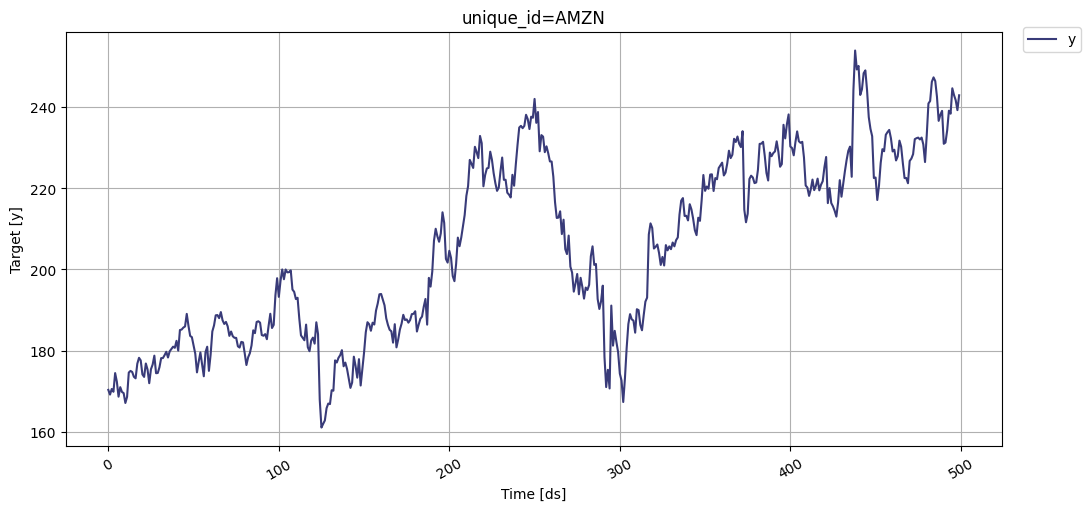

In [ ]:
f = StatsForecast.plot(df)
f.set_figwidth(10)
f.set_figheight(5)
f

#ACF

<function matplotlib.pyplot.show(close=None, block=None)>

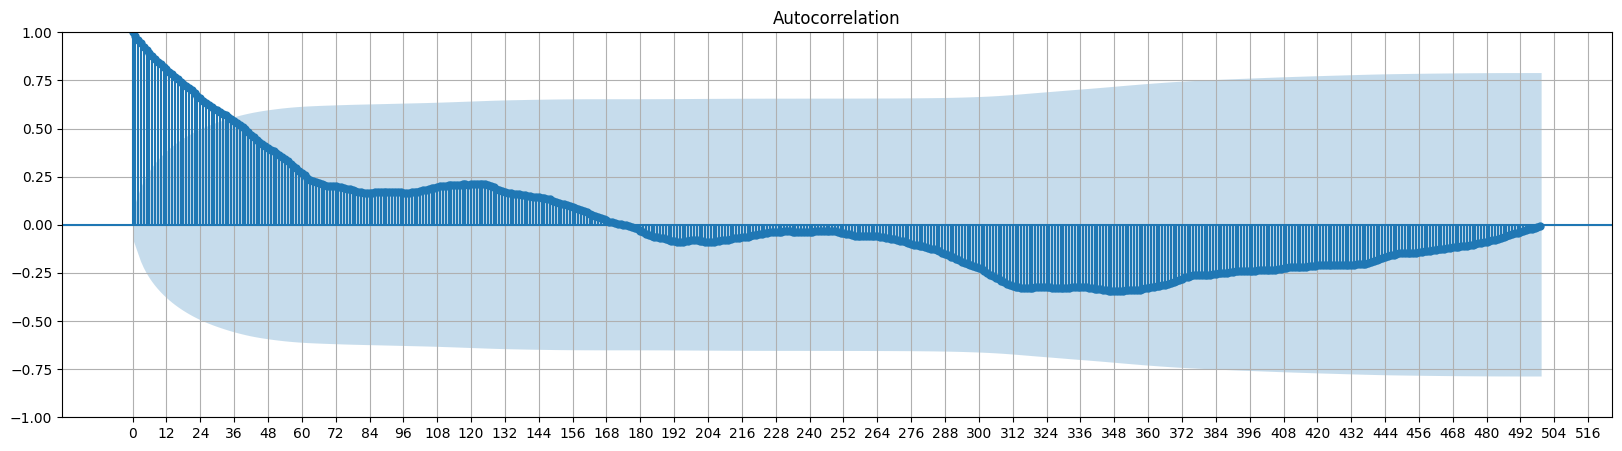

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize = (20,5))
plot_acf(df.y, lags = 499)
plt.xticks(range(0, 520, 12))
plt.show

In [ ]:
import math

n = df.shape[0]
no_of_lags = int(n**0.5)
print(f'Number of lags: {no_of_lags}')

Number of lags: 22


<function matplotlib.pyplot.show(close=None, block=None)>

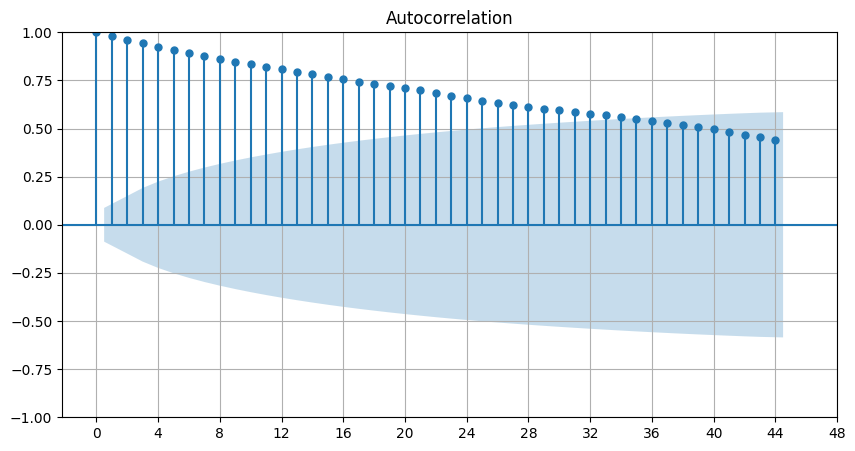

In [ ]:
plt.rc("figure", figsize = (10,5))
plot_acf(df.y, lags = 44)
plt.xticks(range(0, 50, 4))
plt.show

In [ ]:
from coreforecast.seasonal import find_season_length

# find_season_length(df.y.values, max_season_length= 500)

# Try with a larger max_season_length
season_raw = find_season_length(df.y.values, max_season_length=250)
print(f"Season length (raw data, max 250): {season_raw}")


Season length (raw data, max 250): 0
Season length (differenced data): 0


In [ ]:
from coreforecast.seasonal import find_season_length
find_season_length(df.y.values, max_season_length=100)

0

#KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss(df.y)

/tmp/ipython-input-2273521661.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(df.y)


(np.float64(2.750261724840391),
 np.float64(0.01),
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# state vale > critical value

###KPSS test statistic exceeds all critical values and p-value < 0.01, indicating strong evidence of non-stationarity.

## Box-Cox Transformation

In [ ]:
from coreforecast.scalers import boxcox

In [ ]:
from coreforecast.scalers import boxcox_lambda
best_lambda = boxcox_lambda(df.y.values, method='guerrero', season_length=12)
print(best_lambda)

-0.89993088641224


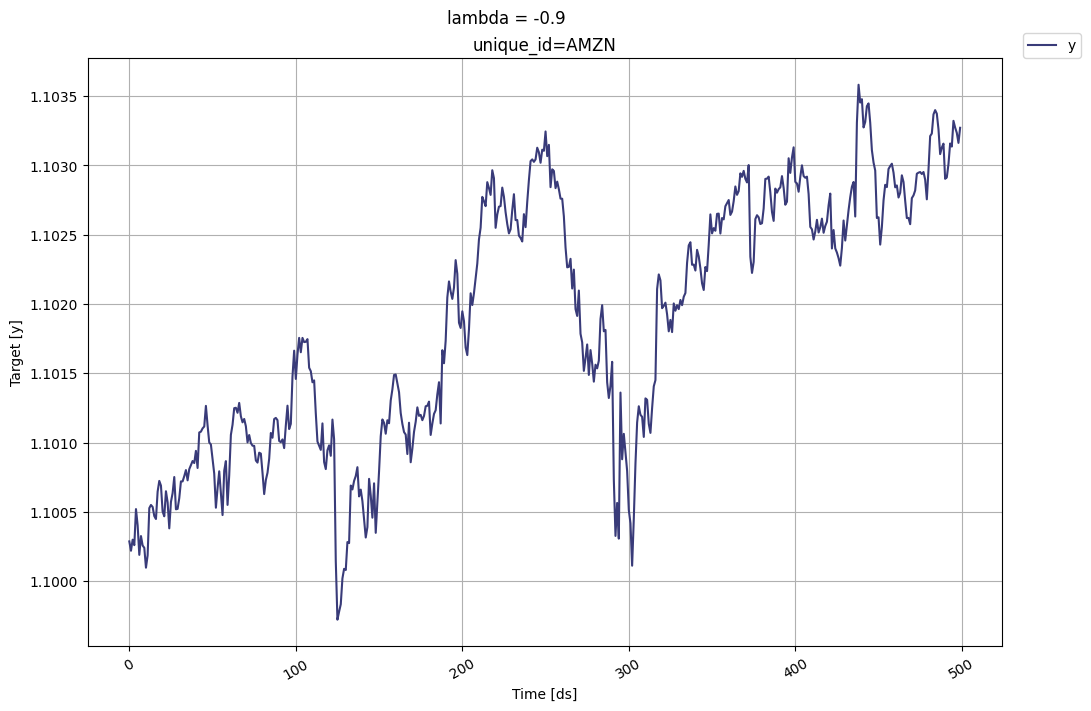

In [ ]:
df_transformed = df.copy()
df_transformed.y = boxcox(df_transformed.y.values, best_lambda)

f = StatsForecast.plot(df_transformed)
f.set_figwidth(10)
f.set_figheight(7)
f.suptitle('lambda = ' + str(round(best_lambda, 3)))
f

#STL decomposition

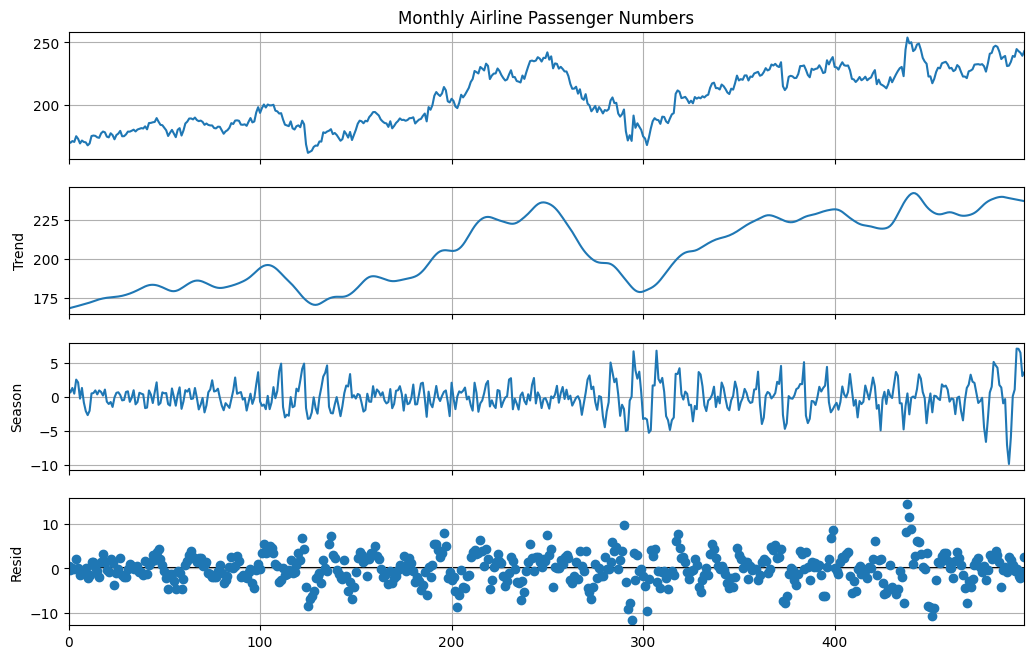

In [ ]:
from statsmodels.tsa.seasonal import STL

air_series = pd.Series(df.y.values, index=df.ds, name="Monthly Airline Passenger Numbers")
res = STL(air_series, period=12).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

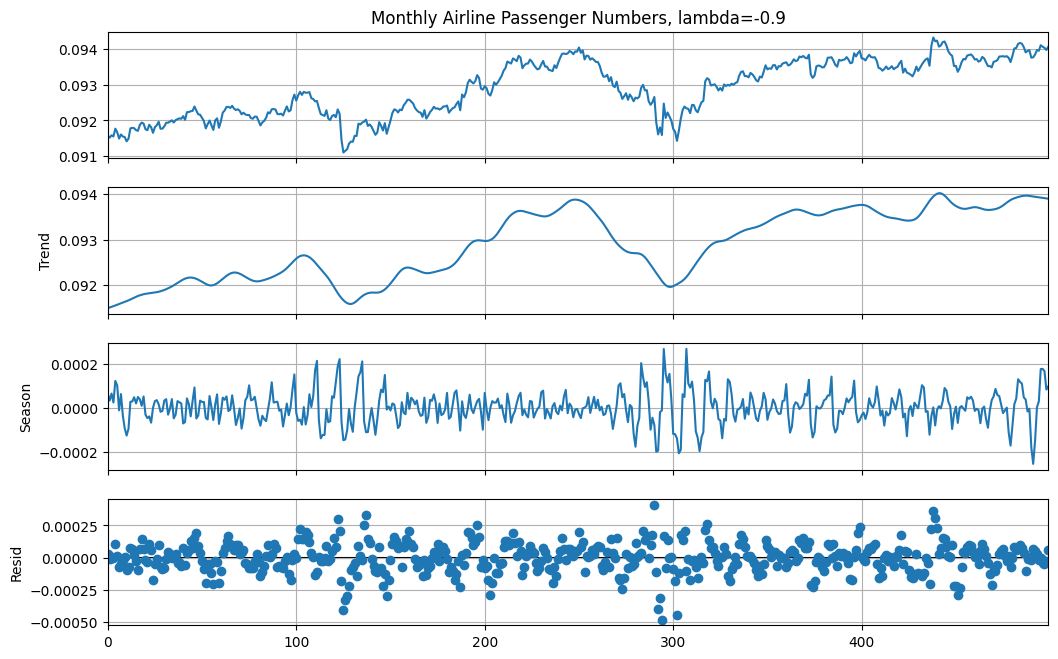

In [ ]:
air_series = pd.Series(df_transformed.y.values, index=df_transformed.ds,
                       name="Monthly Airline Passenger Numbers, lambda="+str(round(best_lambda, 3)))
res = STL(air_series, period=12).fit()
f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)